# Análisis tienda de aplicaciones Google Play 

Las aplicaciones móviles hoy en día están en todos los lugares, son fáciles de crear y pueden dar un retorno de dinero bastante alto. Por esto, cada día son desarrolladas más y más aplicaciones.

En el siguiente Notebook, voy a mostrar un análisis completo del mercado de aplicaciones de Android comparando cerca de 10 mil aplicaciones a través de diferentes categorías. Analizaremos información en los datos, que pueden servir para implementar estrategias de crecimiento y retención

Tenemos dos datasets en formato csv
apps.csv: Contiene todos los detalles de las aplicaciones de google play
user_reviews.csv: Contiene 100 reviews por aplicación. El texto en cada review se ha pre procesado y atribuido a tres nuevas características Sentiment (Positive, Negative or Neutral), Sentiment Polarity y Sentiment Subjectivity.

# Lectura de datos

Vamos a comenzar leyendo los datos del dataset apps.csv, vamos a borrar los datos duplicados, y verificar el número total de aplicaciones en el dataset 

In [1]:
#Importar pandas as pd
import pandas as pd

#Leer los datos del dataset
apps_with_duplicates = pd.read_csv("datasets/apps.csv")

#Borrar los datos duplicados 
apps = apps_with_duplicates.drop_duplicates(subset="App")

#Contar el número total de aplicaciones
print('El número total de aplicaciones en el dataset = ' + str(apps["App"].count()))

#Vamos a ver como está compuesto el dataset observando los primeros 5 registros
print(apps.head(5))

El número total de aplicaciones en el dataset = 9659
   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size     Installs  Type Price  \
0  ART_AND_DESIGN     4.1      159  19.0      10,000+  Free     0   
1  ART_AND_DESIGN     3.9      967  14.0     500,000+  Free     0   
2  ART_AND_DESIGN     4.7    87510   8.7   5,000,000+  Free     0   
3  ART_AND_DESIGN     4.5   215644  25.0  50,000,000+  Free     0   
4  ART_AND_DESIGN     4.3      967   2.8     100,000+  Free     0   

  Content Rating                     Genres      Last Updated  \
0       Everyone               Art & Design   January 7, 2

# Limpieza de datos

La limpieza de datos es una tarea esencial en cualquier projecto de ciencia de datos, aunque puede ser muy tedioso, es muy importante, ya que pueden alterar los resultados

Inspeccionando el dataset, podemos ver que columnas como "Installs" o "Price". Estas columnas tienen varios caractéres especiales (+,$), lo que impide que sean tratadas como datos numéricos, ya sea float o int, y que podamos usarlas para realizar operaciones matemáticas. Idealmente, estos campos deberían tener solo datos númericos <0-9>

Vamos a limpiar los caracteres especiales de la columna "Installs" (+,) y de la columna "Price" ($)

In [2]:
#Lista de caracteres que vamos a remover
chars_to_remove = ['+',',','$']

#Lista de columnas donde vamos a remover los caracteres
cols_to_clean = ['Installs', 'Price']

#Remover los datos
#Verificamos cada dato en la lista de columnas con la variable col
for col in cols_to_clean:
    #Verificamos cada dato en la lista de caracteres con la variable char
    for char in chars_to_remove:
        #Reemplazamos el caracter con un string vacío
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))
        
#Vemos como quedó el dataframe nuevamente:
#Aplicaciones y vemos que Installs ahora no tiene los caracteres especiales
print(apps.head(5))
print('-----------------------------------------------------------------------------------------------------')
#Aplicaciones pagas, vemos que ya no existe el caracter especial $
print(apps[apps['Type']=='Paid'].head(5))
print('-----------------------------------------------------------------------------------------------------')
#Resumen de la información del dataset
print(apps.info())

   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size  Installs  Type Price Content Rating  \
0  ART_AND_DESIGN     4.1      159  19.0     10000  Free     0       Everyone   
1  ART_AND_DESIGN     3.9      967  14.0    500000  Free     0       Everyone   
2  ART_AND_DESIGN     4.7    87510   8.7   5000000  Free     0       Everyone   
3  ART_AND_DESIGN     4.5   215644  25.0  50000000  Free     0           Teen   
4  ART_AND_DESIGN     4.3      967   2.8    100000  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   Jan

# Corrección del tipo de datos

Los datos con los cuales más vamos a trabajar son "Installs", "Size", "Rating" y "Price". En el paso anterior, removimos caracteres especiales de las columnas "Installs" y "Price", pero verificando su tipo, podemos ver que aún están como objetos, necesitamos convertirlas en caractéres numéricos para poder realizar operaciones con ellas

In [3]:
#Convertimos Installs a tipo float
apps['Installs'] = apps['Installs'].astype(float)

#Convertimos Price a tipo float
apps['Price'] = apps['Price'].astype(float)

#Veamos la información nuevamente
print(apps.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9658
Data columns (total 14 columns):
Unnamed: 0        9659 non-null int64
App               9659 non-null object
Category          9659 non-null object
Rating            8196 non-null float64
Reviews           9659 non-null int64
Size              8432 non-null float64
Installs          9659 non-null float64
Type              9659 non-null object
Price             9659 non-null float64
Content Rating    9659 non-null object
Genres            9659 non-null object
Last Updated      9659 non-null object
Current Ver       9651 non-null object
Android Ver       9657 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 1.1+ MB
None


# Categorías de aplicaciones

Google play tiene más de 1 billón de usuarios activos en 190 países. Para que los negocios puedan presentar sus aplicaciones a los usuarios, es importante que los usuarios tengan facilidad para descubrirlas. Por eso Google, comenzó a agrupar las aplicaiones por Categorias

Esto nos genera las siguientes preguntas

<li>¿Hay alguna categoría dominante en el mercado?</li>
<li>¿Qué categorías tienen la menor cantidad de aplicaciones?</li>



In [12]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

#Contemos el número de categorías
num_categories = apps['Category'].nunique()
print("El número de categorias es ", num_categories)

print('--------------------------------------------------------------')

#Contamos el número de aplicaciones en cada categoría
num_apps_in_category = apps['Category'].value_counts()

#Ordenamos el número de apps en categorías en orden descendente basado en el número de apps en cada categoría
sorted_num_apps_in_category = num_apps_in_category.sort_values(ascending=False)
print(sorted_num_apps_in_category)

data = [go.Bar(
        x = num_apps_in_category.index, # index = category name
        y = num_apps_in_category.values, # value = count
)]

plotly.offline.iplot(data)

El número de categorias es  33
--------------------------------------------------------------
FAMILY                 1832
GAME                    959
TOOLS                   827
BUSINESS                420
MEDICAL                 395
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  325
COMMUNICATION           315
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  171
VIDEO_PLAYERS           163
MAPS_AND_NAVIGATION     131
EDUCATION               119
FOOD_AND_DRINK          112
ENTERTAINMENT           102
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  79
HOUSE_AND_HOME           74
ART_AND_DESIGN           64
EVENTS                   64
PARENTING                60
COMICS                   56
BEAUTY    

# Distribución de rating de las aplicaciones

Vimos como se distribuían las aplicaciones por categoría, ahora vamos a ver como se distribuyen las aplicaciones por rating. El rating se mide en una escala de 1 a 5. El rating es un indicador de rendimiento clave para las aplicaciones

Vamos a ver a continuación que el promedio de rating entre todas las categorías es de 4.17. También vemos que la mayoría de las aplicaciones están bien calificadas, mientras que unas pocas están a la izquierda, como mal calificadas

In [25]:
#Rating promedio de todas las aplicaciones
avg_app_rating = apps['Rating'].mean()
print("El promedio de rating de las aplicaciones es ", avg_app_rating)

#Distribución de las aplicaciones de acuerdo a los ratings
data = [go.Histogram(
            x= apps['Rating']
)]

#Linea vertical que indica el promedio de cada app

layout = {'shapes':[{
        'type' :'line',
        'x0': avg_app_rating,
        'y0': 0,
        'x1': avg_app_rating,
        'y1': 1000,
        'line': { 'dash': 'dashdot'}
    }]
    }

plotly.offline.iplot({'data': data, 'layout': layout})

El promedio de rating de las aplicaciones es  4.173243045387998


# Tamaño y costo de una aplicación

Vamos a examinar las aplicaciones por tamaño y por precio. Cuanto más grande sea una aplicación, más dificultad tendrá el usuario al descargarla (Tiempo, espacio en su dispositivo, costo etc). Estos problemas van a depender de cual sea tu público objetivo 

Así que cuales estrategias serían mejores para tu app?

<li>¿El tamaño de una aplicación afecta su rating?</li>
<li>¿Los usuarios prefieren aplicaciones pesadas o livianas?</li>
<li>¿El precio de una aplicación afecta su rating?</li>
<li>¿Los usuarios prefieren aplicaciones gratis sobre aplicaciones pagas?</li>

Vamos a ver que la mayoría de aplicaciones tienen un precio menor a $10, y que las aplicaciones con mejor calificación tienen un tamaño entre 2MB y 20MB

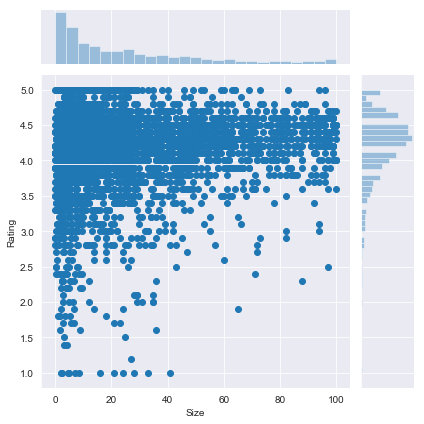

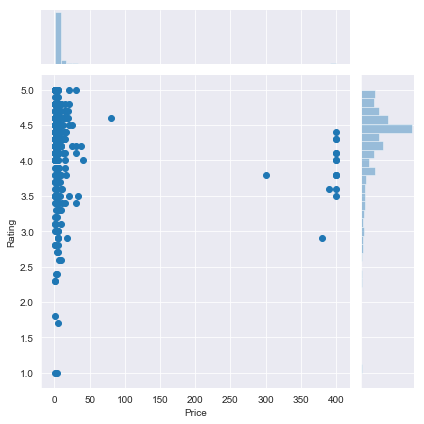

In [33]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

#Seleccionar filas donde el Rating y el tamaño estén presente (Que su valor no sea null)
apps_with_size_and_rating_present = apps.dropna(subset=['Size','Rating'])

#Vamos a tomar una muestra con las categorías que tengan al menos 250 aplicaciones
large_categories = apps_with_size_and_rating_present.groupby('Category').filter(lambda x: len(x) > 250)

#Graficamos Tamaño vs Rating
plt1 = sns.jointplot(x=large_categories['Size'], y=large_categories['Rating'])

#Seleccionar aplicaciones que su tipo sean pagas
paid_apps = apps_with_size_and_rating_present[apps_with_size_and_rating_present['Type']=='Paid']

#Graficamos Precio vs Rating
plt2 = sns.jointplot(x= paid_apps['Price'], y=paid_apps['Rating'])

# Relación entre la categoría de la app y el precio

¿Cómo se supone que las empresas y los desarrolladores lleguen a fin de mes? ¿Qué estrategias de monetización pueden utilizar las empresas para maximizar las ganancias? Los costos de las aplicaciones se basan en gran medida en las características, la complejidad y la plataforma.

Hay muchos factores a considerar al seleccionar la estrategia de precios adecuada para la aplicación móvil. Es importante considerar si el cliente está dispuesto a pagar por la aplicación. Un precio incorrecto podría desmotivar al cliente y cancelar la compra antes de que ocurra la descarga. Los clientes potenciales pueden desanimarse por lo que perciben como un costo impactante, o también pueden eliminar una aplicación que han descargado después de recibir demasiados anuncios o simplemente no ver reflejado el valor de su dinero

Las diferentes categorías exigen diferentes rangos de precios. Algunas aplicaciones que son simples y se usan a diario, como la calculadora, aplicaciones de este tipo, probablemente deben mantenerse gratuitas. Sin embargo, tendría sentido cobrar por una aplicación médica altamente especializada que diagnostica a pacientes diabéticos. En seguida vamos a ver que las aplicaciones médicas y familiares son las más caras. Algunas aplicaciones médicas llegan a costar hasta $ 80, mientras que casi todas las aplicaciones de juegos tienen un precio razonable por debajo de $ 20.

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


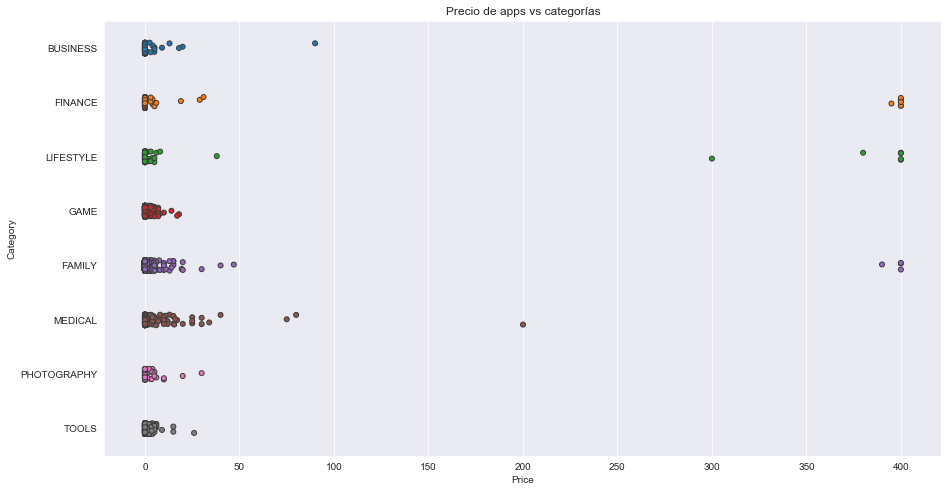

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

#Vamos a seleccionar solo algunas categorías

popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

#Examinemos el precio de la app graficando Precio vs Categoría
ax = sns.stripplot(x = popular_app_cats["Price"], y = popular_app_cats["Category"], jitter=True, linewidth=1)
ax.set_title('Precio de apps vs categorías')

# Apps cuyo precio es mayor a $200
apps_above_200 = apps[apps['Price']>200]
apps_above_200[['Category', 'App', 'Price']]

# Filtremos las aplicaciones basura

Parece que hay mucha información, para solo haber filtrado unas cuantas categorías, no? Hay muchas aplicaciones que son basura, significa que no tienen propósito, muchas veces desarrolladores crean aplicaciones como "I am Rich Premium"  o "Most Expensive App Ever" como broma o para efectuar tests en sus aplicaciones 

Vamos a quitar estas aplicaciones y volver a hacer nuestra gráfica

Text(0.5, 1.0, 'Precio de todas las apps vs categorías, sin información basura')

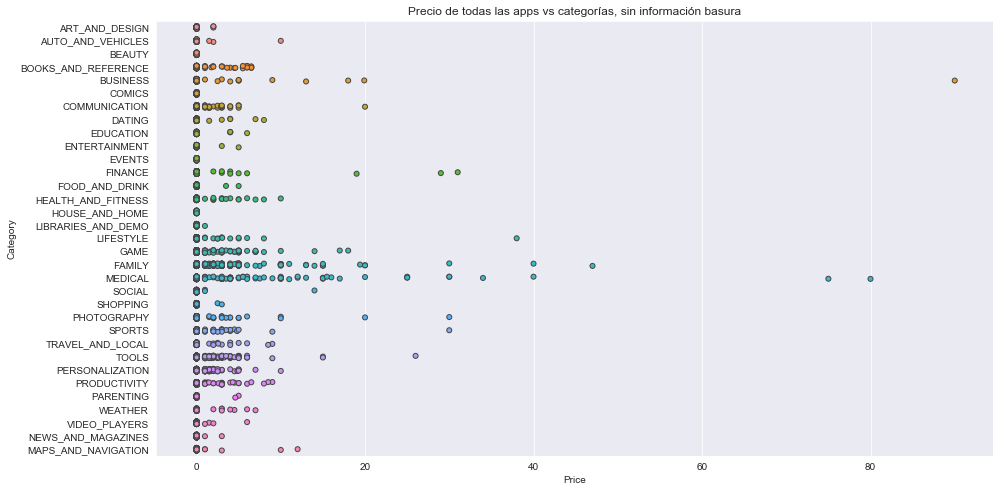

In [36]:
# Aplicaciones por debajo de $100
apps_under_100 = apps[apps['Price'] <= 100]
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Vamos a examinar ahora precio vs categoría con las apps que cuestan menos de $100
ax = sns.stripplot(x = apps_under_100['Price'], y = apps_under_100['Category'], data = apps_under_100, jitter = True, linewidth = 1)
ax.set_title('Precio de todas las apps vs categorías, sin información basura')

# Popularidad de aplicaciones pagas vs gratis

Para las aplicaciones de la Google Play Store, existen cinco tipos de estrategias de precios: gratis, freemium, de pago, paymium y suscripción. Pero vamos a enfocarnos en las aplicaciones pagas y gratis

Características de las aplicaciones grátis:

<li>Son de descarga gratis</li>
<li>A veces son creadas por empresas que tienen otros productos, y esas apps terminan siendo extensiones de estos</li>
<li>Su principal fuente de ingresos, suele ser publicidad</li>

Características de las aplicaciones pagas:

<li>Los usuarios suelen pagar una vez, y usan para siempre</li>
<li>El usuario no puede tener una completa visión de la aplicación sin comprarla, solo una muestra gratis</li>

Las aplicaciones pagas son tan descargadas como las gratis? 

In [38]:
trace0 = go.Box(
    # Data para aplicaciones pagas
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Paid'
)

trace1 = go.Box(
    # Data para aplicaciones grátis
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Free'
)

layout = go.Layout(
    title = "Numero de descargas: Apps gratis vs Apps Pagas",
    yaxis = dict(title = "Número de descargas",
                type = 'log',
                autorange = True)
)

# Añadimos trace0 (pagas) y trace1 (gratis) para graficar
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

# Análisis de sentimientos de los usuarios

La extracción de datos de reseñas de usuarios para determinar cómo se sienten las personas acerca de su producto, marca o servicio se puede realizar mediante una técnica llamada análisis de sentimientos. Las reseñas de los usuarios de las aplicaciones se pueden analizar para identificar si el estado de ánimo es positivo, negativo o neutral con respecto a esa aplicación. Por ejemplo, las palabras positivas en la reseña de una aplicación pueden incluir palabras como "asombroso", "amigable", "bueno", "excelente" y "amo". Las palabras negativas pueden ser palabras como "malware", "odio", "problema", "reembolso" e "incompetente".

Al graficar los puntajes de polaridad de sentimiento de las opiniones de los usuarios para aplicaciones pagas y gratuitas, observamos que las aplicaciones gratuitas reciben muchos comentarios negativos, como lo indican los valores atípicos en el eje y negativo. Las reseñas de aplicaciones pagas nunca parecen ser muy negativas. Esto puede indicar algo sobre la calidad de la aplicación, es decir, que las aplicaciones pagas son de mayor calidad que las aplicaciones gratuitas en promedio.

                     App                                             Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000  
   Unnamed: 0                  App        Category  Rating  Reviews  Size  \
0           1  Coloring book moana  ART_AND_DESIGN     3.9      967  14.0   
1           1  Coloring

Text(0.5, 1.0, 'Distribución de la polaridad sentimental')

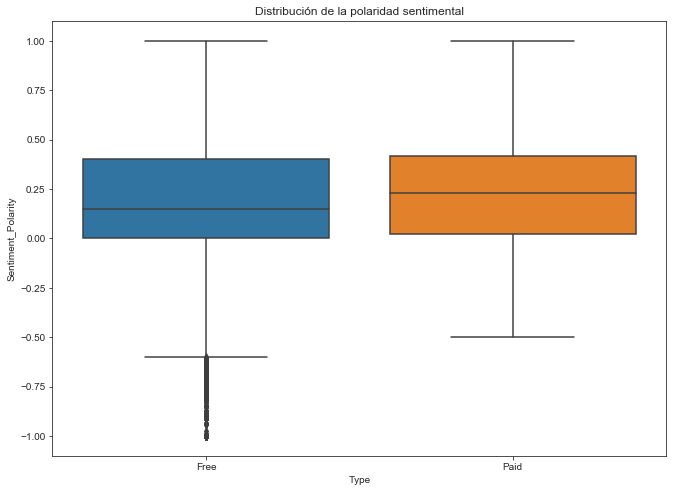

In [39]:
# Vamos a cargar el dataset user_reviews.csv
reviews_df = pd.read_csv('datasets/user_reviews.csv')
print(reviews_df.head())

# Juntamos los dos datasets, apps y reviews_df
merged_df = pd.merge(apps,reviews_df)

# Borramos los valores nulos (NA) de las columnas Sentiment y Review
merged_df = merged_df.dropna(subset = ['Sentiment', 'Review'])

print(merged_df.head())

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# Polaridad de opinión entre los usuarios de aplicaciones pagas y gratuitas
ax = sns.boxplot(x = merged_df['Type'], y = merged_df['Sentiment_Polarity'], data = merged_df)
ax.set_title('Distribución de la polaridad sentimental')